## Joining PRISM Climate Data and CCH2 Specimens

Warning: This notebook requires 32Gb of RAM in order to run. Anything less will cause the kernel to die while trying to append the climate columns.

In [1]:
import numpy as np
import pandas as pd

In [2]:
import gc

In [3]:
def read_prism_hdr(hdr_path):
    """Read an ESRI BIL HDR file"""
    with open(hdr_path, 'r') as input_f:
        header_list = input_f.readlines()
    output = dict(item.strip().split() for item in header_list)
    return output

def read_prism_bil(bil_path):
    """Read an array from ESRI BIL raster file"""
    hdr_dict = read_prism_hdr(bil_path.replace('.bil', '.hdr'))
    # For now, only use NROWS, NCOLS, and NODATA
    # Eventually use NBANDS, BYTEORDER, LAYOUT, PIXELTYPE, NBITS
    prism_array = np.fromfile(bil_path, dtype=np.float32)
    prism_array = prism_array.reshape(
        int(hdr_dict['NROWS']), int(hdr_dict['NCOLS']))
    prism_array[prism_array == float(hdr_dict['NODATA'])] = np.nan
    return prism_array, hdr_dict

def get_prism_data(attribute):
    years = range(1895, 2020)
    months = range(1, 13)
    arrays = []
    headers = {}
    for yr in years:
        annual_arrays = []
        for month in months:
            ver = 2 if (yr < 1981 and attribute == "ppt") else 3
            prism_path = 'prism_climate_data/{}/{}/PRISM_{}_stable_4kmM{}_{}{:02d}_bil.bil'.format(attribute,yr,attribute,ver,yr,month)
            prism_array, prism_header = read_prism_bil(prism_path)
            headers[(yr, month)] = prism_header
            annual_arrays.append(prism_array)
        arrays.append(np.stack(annual_arrays, axis=0))
    
    # 2020 is partial, so we need to append some extra null arrays
    annual_arrays = []
    for month in months:
        if month < 5:
            prism_path = 'prism_climate_data/{}/{}/PRISM_{}_stable_4kmM3_{}{:02d}_bil.bil'.format(attribute,yr,attribute,yr,month)
            prism_array, prism_header = read_prism_bil(prism_path)
            headers[(yr, month)] = prism_header
            annual_arrays.append(prism_array)
        else:
            arr = np.zeros((621,1405))
            arr[:,:] = np.nan
            annual_arrays.append(arr)
    arrays.append(np.stack(annual_arrays, axis=0))
    
    prism_array = np.stack(arrays, axis=0)
    
    # Check to make sure the headers are the same for each year
    for k, h in headers.items():
        for hk, hv in prism_header.items():
            if hk in ["ULXMAP", "ULYMAP", "XDIM", "YDIM", "NODATA"]:
                # Check the approximate equivalence of float values
                if round(float(h[hk]), 5) != round(float(hv),5):
                    raise ValueError("{} differs from last header ({} being {} vs {})".format(k, hk, h[hk], hv))
            else:
                # Check exact equivalence of ints and strings
                if h[hk] != hv:
                    raise ValueError("{} differs from last header ({} being {} vs {})".format(k, hk, h[hk], hv))
    
    return prism_array, prism_header

def get_prism_coords(coords, header):
    result = coords.copy()
    result[0] -= (float(header["ULXMAP"]) - float(header["XDIM"])/2.0)
    result[0] /= float(header["XDIM"])
    result[1] -= (float(header["ULYMAP"]) + float(header["YDIM"])/2.0)
    result[1] /= -float(header["YDIM"])
    return result

def lookup_climate_data(records, # Pandas Dataframe
                        prism_array, # Numpy Ndarray of shape (years, months, lat_bins, lon_bins)
                        prism_header, # Header for prism data
                        col_name, # Name of data being computed
                        month_override=None, # Override month indexing to take a single value
                        normalized=True): # If true, subtract the mean over the observed period (1895-2020)
    print("Calculating {}...".format(col_name))
    
    # Drop rows with any null indexing variables
    initial_len = len(records)
    records = records.dropna(subset=["year", "decimalLongitude", "decimalLatitude"])
    
    # Drop rows that are out of bounds on any axis
    minLon = float(prism_header["ULXMAP"]) - float(prism_header["XDIM"])/2.0
    maxLon = minLon + prism_array.shape[3] * float(prism_header["XDIM"])
    maxLat = float(prism_header["ULYMAP"]) + float(prism_header["YDIM"])/2.0
    minLat = maxLat - prism_array.shape[2] * float(prism_header["YDIM"])
    records = records.loc[  (records["year"] >= 1895)
                          & (records["year"] <= 2020)
                          & (records["decimalLatitude"] > minLat)
                          & (records["decimalLatitude"] < maxLat)
                          & (records["decimalLongitude"] > minLon)
                          & (records["decimalLongitude"] < maxLon)]
    
    # Handle month separately as it is sometimes uneccesary
    if month_override is None:
        records = records.dropna(subset=["month"])
        records = records.loc[(records["month"] >= 1) & (records["month"] <= 12)]
    
    final_len = len(records)
    print("{}/{} records do not have good year/month/lat/lon".format(initial_len - final_len,
                                                                     initial_len))
    coords = get_prism_coords(records[["decimalLongitude", "decimalLatitude"]].values.T,
                              prism_header).astype(int)
    if month_override is None:
        # Index by the month in which each sample was collected
        month_index = records["month"].values
    else:
        # Index by a specified month
        month_index = month_override
    
    vals = prism_array[records["year"].values-1895, # Year indexed from 1895
                       month_index-1, # Month indexed from January
                       coords[1], # Transformed latitude
                       coords[0]] # Transformed longitude
    
    if normalized:
        # Compute the mean over all years and subtract from vals
        vals -= np.nanmean(prism_array,axis=0)[month_index-1,coords[1],coords[0]]
    
    return pd.Series(vals.copy(), index=records.index, name=col_name)

def add_climate_columns(dataframe, attribute):
    final_climate_columns = []
    prism_array, prism_header = get_prism_data(attribute)
    
    # At collection time
    col_name = "{}_at_collection".format(attribute)
    final_climate_columns.append(col_name)
    new_col = lookup_climate_data(dataframe, prism_array, prism_header, col_name)
    dataframe[new_col.name] = np.nan
    dataframe.loc[new_col.index, new_col.name] = new_col
    # Winter (January)
    col_name = "{}_winter".format(attribute)
    final_climate_columns.append(col_name)
    new_col = lookup_climate_data(dataframe, prism_array, prism_header, col_name, month_override=1)
    dataframe[new_col.name] = np.nan
    dataframe.loc[new_col.index, new_col.name] = new_col
    # Spring (April)
    col_name = "{}_spring".format(attribute)
    final_climate_columns.append(col_name)
    new_col = lookup_climate_data(dataframe, prism_array, prism_header, col_name, month_override=4)
    dataframe[new_col.name] = np.nan
    dataframe.loc[new_col.index, new_col.name] = new_col
    # Summer (July)
    col_name = "{}_summer".format(attribute)
    final_climate_columns.append(col_name)
    new_col = lookup_climate_data(dataframe, prism_array, prism_header, col_name, month_override=7)
    dataframe[new_col.name] = np.nan
    dataframe.loc[new_col.index, new_col.name] = new_col
    # Fall (October)
    col_name = "{}_fall".format(attribute)
    final_climate_columns.append(col_name)
    new_col = lookup_climate_data(dataframe, prism_array, prism_header, col_name, month_override=10)
    dataframe[new_col.name] = np.nan
    dataframe.loc[new_col.index, new_col.name] = new_col
    
    return dataframe

In [4]:
merged_dir = "continental_US_CCH2"
cch2 = pd.read_csv(merged_dir + "/full_dataset.csv")
cch2["year"] = cch2["year"].astype(int)
cch2["month"] = cch2["month"].astype(int)

/home/jackson/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (3,26,28,42,44,50,56,65,67,73,75) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
cch2 = add_climate_columns(cch2, "ppt")
gc.collect()

Calculating ppt_at_collection...
864/1510985 records do not have good year/month/lat/lon


<ipython-input-3-35a524277b9c>:120: RuntimeWarning: Mean of empty slice
  vals -= np.nanmean(prism_array,axis=0)[month_index-1,coords[1],coords[0]]


Calculating ppt_winter...
864/1510985 records do not have good year/month/lat/lon


<ipython-input-3-35a524277b9c>:120: RuntimeWarning: Mean of empty slice
  vals -= np.nanmean(prism_array,axis=0)[month_index-1,coords[1],coords[0]]


Calculating ppt_spring...
864/1510985 records do not have good year/month/lat/lon


<ipython-input-3-35a524277b9c>:120: RuntimeWarning: Mean of empty slice
  vals -= np.nanmean(prism_array,axis=0)[month_index-1,coords[1],coords[0]]


Calculating ppt_summer...
864/1510985 records do not have good year/month/lat/lon


<ipython-input-3-35a524277b9c>:120: RuntimeWarning: Mean of empty slice
  vals -= np.nanmean(prism_array,axis=0)[month_index-1,coords[1],coords[0]]


Calculating ppt_fall...
864/1510985 records do not have good year/month/lat/lon


<ipython-input-3-35a524277b9c>:120: RuntimeWarning: Mean of empty slice
  vals -= np.nanmean(prism_array,axis=0)[month_index-1,coords[1],coords[0]]


0

0.06230571448426027


<AxesSubplot:ylabel='Frequency'>

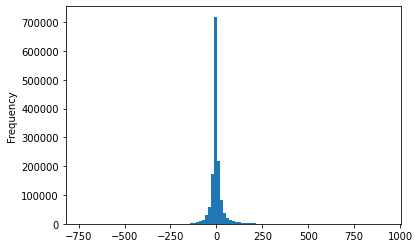

In [6]:
print(cch2["ppt_at_collection"].isna().sum()/len(cch2))
cch2["ppt_at_collection"].plot.hist(bins=101)

In [7]:
cch2 = add_climate_columns(cch2, "tmin")
gc.collect()

Calculating tmin_at_collection...
864/1510985 records do not have good year/month/lat/lon


<ipython-input-3-35a524277b9c>:120: RuntimeWarning: Mean of empty slice
  vals -= np.nanmean(prism_array,axis=0)[month_index-1,coords[1],coords[0]]


Calculating tmin_winter...
864/1510985 records do not have good year/month/lat/lon


<ipython-input-3-35a524277b9c>:120: RuntimeWarning: Mean of empty slice
  vals -= np.nanmean(prism_array,axis=0)[month_index-1,coords[1],coords[0]]


Calculating tmin_spring...
864/1510985 records do not have good year/month/lat/lon


<ipython-input-3-35a524277b9c>:120: RuntimeWarning: Mean of empty slice
  vals -= np.nanmean(prism_array,axis=0)[month_index-1,coords[1],coords[0]]


Calculating tmin_summer...
864/1510985 records do not have good year/month/lat/lon


<ipython-input-3-35a524277b9c>:120: RuntimeWarning: Mean of empty slice
  vals -= np.nanmean(prism_array,axis=0)[month_index-1,coords[1],coords[0]]


Calculating tmin_fall...
864/1510985 records do not have good year/month/lat/lon


<ipython-input-3-35a524277b9c>:120: RuntimeWarning: Mean of empty slice
  vals -= np.nanmean(prism_array,axis=0)[month_index-1,coords[1],coords[0]]


12

0.06230571448426027


<AxesSubplot:ylabel='Frequency'>

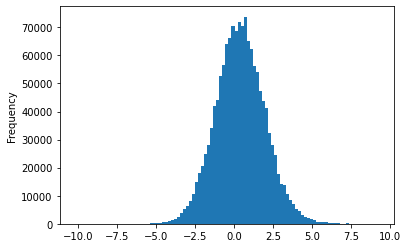

In [8]:
print(cch2["tmin_at_collection"].isna().sum()/len(cch2))
cch2["tmin_at_collection"].plot.hist(bins=101)

In [9]:
cch2 = add_climate_columns(cch2, "tmean")
gc.collect()

Calculating tmean_at_collection...
864/1510985 records do not have good year/month/lat/lon


<ipython-input-3-35a524277b9c>:120: RuntimeWarning: Mean of empty slice
  vals -= np.nanmean(prism_array,axis=0)[month_index-1,coords[1],coords[0]]


Calculating tmean_winter...
864/1510985 records do not have good year/month/lat/lon


<ipython-input-3-35a524277b9c>:120: RuntimeWarning: Mean of empty slice
  vals -= np.nanmean(prism_array,axis=0)[month_index-1,coords[1],coords[0]]


Calculating tmean_spring...
864/1510985 records do not have good year/month/lat/lon


<ipython-input-3-35a524277b9c>:120: RuntimeWarning: Mean of empty slice
  vals -= np.nanmean(prism_array,axis=0)[month_index-1,coords[1],coords[0]]


Calculating tmean_summer...
864/1510985 records do not have good year/month/lat/lon


<ipython-input-3-35a524277b9c>:120: RuntimeWarning: Mean of empty slice
  vals -= np.nanmean(prism_array,axis=0)[month_index-1,coords[1],coords[0]]


Calculating tmean_fall...
864/1510985 records do not have good year/month/lat/lon


<ipython-input-3-35a524277b9c>:120: RuntimeWarning: Mean of empty slice
  vals -= np.nanmean(prism_array,axis=0)[month_index-1,coords[1],coords[0]]


12

0.06230571448426027


<AxesSubplot:ylabel='Frequency'>

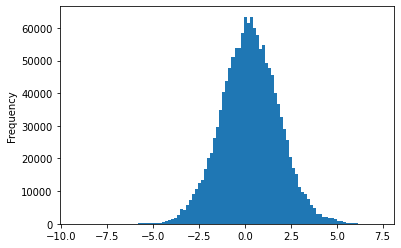

In [10]:
print(cch2["tmean_at_collection"].isna().sum()/len(cch2))
cch2["tmean_at_collection"].plot.hist(bins=101)

In [11]:
cch2 = add_climate_columns(cch2, "tmax")
gc.collect()

Calculating tmax_at_collection...
864/1510985 records do not have good year/month/lat/lon


<ipython-input-3-35a524277b9c>:120: RuntimeWarning: Mean of empty slice
  vals -= np.nanmean(prism_array,axis=0)[month_index-1,coords[1],coords[0]]


Calculating tmax_winter...
864/1510985 records do not have good year/month/lat/lon


<ipython-input-3-35a524277b9c>:120: RuntimeWarning: Mean of empty slice
  vals -= np.nanmean(prism_array,axis=0)[month_index-1,coords[1],coords[0]]


Calculating tmax_spring...
864/1510985 records do not have good year/month/lat/lon


<ipython-input-3-35a524277b9c>:120: RuntimeWarning: Mean of empty slice
  vals -= np.nanmean(prism_array,axis=0)[month_index-1,coords[1],coords[0]]


Calculating tmax_summer...
864/1510985 records do not have good year/month/lat/lon


<ipython-input-3-35a524277b9c>:120: RuntimeWarning: Mean of empty slice
  vals -= np.nanmean(prism_array,axis=0)[month_index-1,coords[1],coords[0]]


Calculating tmax_fall...
864/1510985 records do not have good year/month/lat/lon


<ipython-input-3-35a524277b9c>:120: RuntimeWarning: Mean of empty slice
  vals -= np.nanmean(prism_array,axis=0)[month_index-1,coords[1],coords[0]]


12

0.06230571448426027


<AxesSubplot:ylabel='Frequency'>

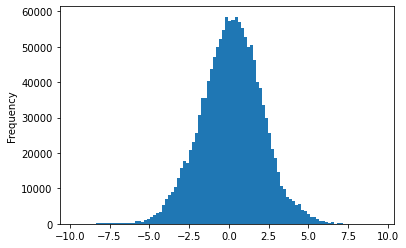

In [12]:
print(cch2["tmax_at_collection"].isna().sum()/len(cch2))
cch2["tmax_at_collection"].plot.hist(bins=101)

## Save the Resulting Dataset

In [21]:
cch2.to_csv(merged_dir + "/full_dataset.csv", index=False)